# Cats vs dogs. Transfer learning.
## A binary classifier (either cat or dog) is used.
## This shows how to use transfer learning
### Keras and VGG16 will be used

In [1]:
# Lets import some stuff
import tensorflow as tf
from skimage import io
from IPython.display import Image
from PIL import Image as PILImage
import pandas as pd

#from skimage.transform import resize
import matplotlib.pyplot as plt
from os import listdir
from os import mkdir
from skimage.io import imsave
import numpy as np
from sklearn.utils import shuffle
import sys
#import os
import cv2

In [2]:
FLOYDHUB=True
if FLOYDHUB:
    OUTPUT_DIR = "/output/"
    DATA_DIR = "/input/"
    CLEANED_DATA_DIR = "/input/"
else:
    OUTPUT_DIR = "/tmp/"
    DATA_DIR = "data/train/"
    CLEANED_DATA_DIR = "data/augmented/"



### Explore the dataset

The definition of kaggle dataset is 

"The training archive contains 25,000 images of dogs and cats. Train your algorithm on these files and predict the labels for test1.zip (1 = dog, 0 = cat)."

Notice! your direcory should look like this (once you have uncompressed the data)
```
.
├── cats-vs-dogs.ipynb
└── data
    └── train [25000 entries exceeds filelimit, not opening dir]
            ├── cat.2976.jpg
            ├── dog.2977.jpg
            ├── cat.2978.jpg
            ├── dog.2979.jpg
            ├── ...

```
Of course images named cat.xxx.jpg are cats and thesame goes for the ones started with dogs.

Lets open a few images


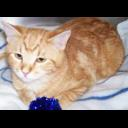

In [3]:
Image(filename=DATA_DIR+'cat.42.jpg')


In [4]:
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
def resize_and_pad(img, size, padColor=0):
    # Credits goes to 
    # https://stackoverflow.com/questions/44720580/resize-image-canvas-to-maintain-square-aspect-ratio-in-python-opencv
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    h, w = img.shape[:2]
    sh, sw = size

    # interpolation method
    if h > sh or w > sw: # shrinking image
        interp = cv2.INTER_AREA
    else: # stretching image
        interp = cv2.INTER_CUBIC

    # aspect ratio of image
    aspect = w/h

    # compute scaling and pad sizing
    if aspect > 1: # horizontal image
        new_w = sw
        new_h = np.round(new_w/aspect).astype(int)
        pad_vert = (sh-new_h)/2
        pad_top, pad_bot = np.floor(pad_vert).astype(int), np.ceil(pad_vert).astype(int)
        pad_left, pad_right = 0, 0
    elif aspect < 1: # vertical image
        new_h = sh
        new_w = np.round(new_h*aspect).astype(int)
        pad_horz = (sw-new_w)/2
        pad_left, pad_right = np.floor(pad_horz).astype(int), np.ceil(pad_horz).astype(int)
        pad_top, pad_bot = 0, 0
    else: # square image
        new_h, new_w = sh, sw
        pad_left, pad_right, pad_top, pad_bot = 0, 0, 0, 0

    # set pad color
    if len(img.shape) is 3 and not isinstance(padColor, (list, tuple, np.ndarray)): # color image but only one color provided
        padColor = [padColor]*3

    # scale and pad
    scaled_img = cv2.resize(img, (new_w, new_h), interpolation=interp)
    scaled_img = cv2.copyMakeBorder(scaled_img, pad_top, pad_bot, 
                                    pad_left, pad_right, 
                                    borderType=cv2.BORDER_CONSTANT, value=padColor)

    return scaled_img

In [5]:
original = cv2.imread(DATA_DIR+'cat.42.jpg')
resized = resize_and_pad(original, (IMAGE_HEIGHT, IMAGE_WIDTH))
print(resized.shape)

(128, 128, 3)


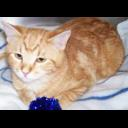

In [6]:
PILImage.fromarray(resized)

In [7]:
try:
    mkdir(CLEANED_DATA_DIR)
except:
    pass

def convert_images(limit=None):
    i = 1
    for image_file in listdir(DATA_DIR):
        if ".jpg" in image_file:
            original = cv2.imread(DATA_DIR+image_file)
            transformed = resize_and_pad(original, (IMAGE_WIDTH, IMAGE_HEIGHT))
            final_file = CLEANED_DATA_DIR+image_file
            imsave(final_file, transformed)
            if i % 500 == 0:
                print("Converted ", i, " images so far...")
            i += 1
        if limit and i > limit:
            break
    print("Done!")

In [8]:
if False:
    convert_images(3000)

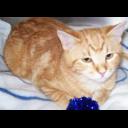

In [9]:
mirrored_image = cv2.flip(resized,1)
PILImage.fromarray(mirrored_image)

In [10]:
def augment_data():
    i = 0
    for image_file in listdir(CLEANED_DATA_DIR):
        original = cv2.imread(CLEANED_DATA_DIR + image_file)
        augmented_image = cv2.flip(original,1)
        final_file = CLEANED_DATA_DIR + image_file
        final_file = final_file.replace(".jpg", ".augmented.jpg")
        #print(final_file)
        imsave(final_file, augmented_image)
        i += 1
        if i % 250 == 0:
            print("Converted %d images so far..." % i)
if False:
    augment_data()

In [11]:
CAT_LABEL = 1
DOG_LABEL = 0

def load_data(limit=None, load_from=0):
    """
    Gets all the data and returns
    X_train_cats, y_train_cats
    X_train_dogs, y_train_dogs
    X_validation_cats, y_validation_cats
    X_validation_dogs, y_validation_dogs
    X_test_cats, y_test_cats
    X_test_dogs, y_test_dogs
    """
    dogs = []
    cats = []
    i = 1
    if limit == None:
        limit = 60000
    expected_shape = (128, 128, 3)
    for image_file in listdir(CLEANED_DATA_DIR):        
        if i >= load_from:
            if ".jpg" in image_file:
                if "dog" in image_file and len(dogs) < limit:
                    raw_image = io.imread(CLEANED_DATA_DIR+image_file)
                    if raw_image.shape != expected_shape:
                        print(CLEANED_DATA_DIR+image_file, "=>", raw_image.shape)
                    else:
                        dogs.append(raw_image)
                elif "cat" in image_file and len(cats) < limit:
                    raw_image = io.imread(CLEANED_DATA_DIR+image_file)
                    if raw_image.shape != expected_shape:
                        print(CLEANED_DATA_DIR+image_file, "=>", raw_image.shape)
                    else:
                        cats.append(raw_image)
        if i % 1000 == 0 and i <= load_from:
            print("Loaded ", i, " images so far...")
        i+=1    
    print("Done!")        
    return cats, dogs

In [12]:
cats, dogs = load_data(limit=5000)

/input/cat.7276.jpg.flop => (128, 128)
/input/cat.4969.jpg.flop => (128, 128)
/input/cat.11184.jpg.flop => (128, 128)
Done!


Now we need to split our data into train, validation and test sets. As there are as many cats as there are dogs, we want to keep our sets balanced, with approximately 50% of cats and 50% of dogs. 

In [13]:
train_limit = int(len(cats) * 0.9)
validation_limit = train_limit + int(len(cats) * 0.05)

X_train_cats = np.array(cats[:train_limit])
X_train_dogs = np.array(dogs[:train_limit])
X_validation_cats = np.array(cats[train_limit:validation_limit])
X_validation_dogs = np.array(dogs[train_limit:validation_limit])
X_test_cats = np.array(cats[validation_limit:])
X_test_dogs = np.array(dogs[validation_limit:])

### Now we need to create our labels, remember that we have dined our labels as variables 
```
CAT_LABEL = 1
DOG_LABEL = 0
```

Meaning that cats are labelled as 1 and dogs as 0s

In [14]:
y_train_cats = np.ones(len(X_train_cats), dtype=np.int8)
y_train_dogs = np.zeros(len(X_train_dogs), dtype=np.int8)
y_validation_cats = np.ones(len(X_validation_cats), dtype=np.int8)
y_validation_dogs = np.zeros(len(X_validation_dogs), dtype=np.int8)
y_test_cats = np.ones(len(X_test_cats), dtype=np.int8)
y_test_dogs = np.zeros(len(X_test_dogs), dtype=np.int8)

In [15]:
X_train = np.append(X_train_cats, X_train_dogs, axis=0)
y_train = np.append(y_train_cats, y_train_dogs)
X_validation = np.append(X_validation_cats, X_validation_dogs, axis=0)
y_validation = np.append(y_validation_cats, y_validation_dogs)
X_test = np.append(X_test_cats, X_test_dogs, axis=0)
y_test = np.append(y_test_cats, y_test_dogs)

del X_train_cats
del X_train_dogs
del X_test_cats
del X_test_dogs
del X_validation_cats
del X_validation_dogs
del y_train_cats
del y_train_dogs
del y_test_cats
del y_test_dogs
del y_validation_cats
del y_validation_dogs

### Lets convert labels into one-hot-encoded values

In [16]:
y_train = np.eye(2)[y_train.reshape(-1)]
y_validation = np.eye(2)[y_validation.reshape(-1)]
y_test = np.eye(2)[y_test.reshape(-1)]

In [17]:
X_validation, y_validation = X_validation[0:1000], y_validation[0:1000]
X_test, y_test = X_test[0:1000], y_test[0:1000]
print("X_train ", X_train.shape, " y_train ", y_train.shape)
print("X_validation ", X_validation.shape, " y_validation ", y_validation.shape)
print("X_test ", X_test.shape, " y_test ", y_test.shape)

X_train  (9000, 128, 128, 3)  y_train  (9000, 2)
X_validation  (500, 128, 128, 3)  y_validation  (500, 2)
X_test  (500, 128, 128, 3)  y_test  (500, 2)


### And finally shuffle the arrays so that our batches are not all dogs or all cats

In [18]:
X_train, y_train = shuffle(X_train, y_train, 
                                            random_state=0)
X_validation, y_validation = shuffle(X_validation, y_validation, 
                                                           random_state=0)
X_test, y_test = shuffle(X_test, y_test, 
                                 random_state=0)

In [19]:
print(y_train[0:5])


[[ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]]


### Now, lets verify that we have shuffled correctly, we will display the first ten images of the train set and check that against the first 5 labels

[ 0.  1.]
This should be a cat...


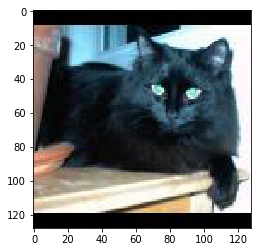

[ 0.  1.]
This should be a cat...


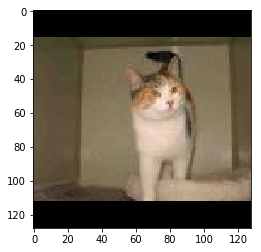

[ 1.  0.]
This should be a dog...


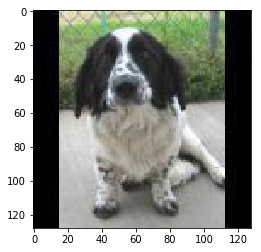

[ 1.  0.]
This should be a dog...


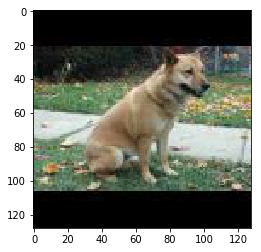

[ 0.  1.]
This should be a cat...


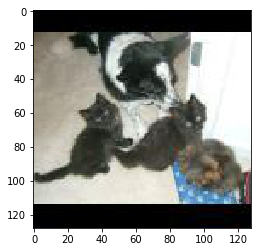

In [20]:
for i in range(5):
    label = y_train[i]
    print(label)
    if label[DOG_LABEL] == 1:
        print("This should be a dog...")
        
    elif label[CAT_LABEL] == 1:
        print("This should be a cat...")
    
    plt.imshow(X_train[i])
    plt.show()

### We still need to normalize our data, remember that normalization is done with the following formula
![title](normalization.png)

In [21]:
def normalize(raw_data):
    # TODO Figure this out
    # NOTE USE EITHER mean centering or min-max, NOT BOTH
    
    # Min and max values are 0 and 255
    raw_data = (raw_data - 0) / (255 - 0)
    
    # Mean centering
    #raw_data = (raw_data - raw_data.mean()) / raw_data.std()
    
    return raw_data


X_train = normalize(X_train)
X_validation = normalize(X_validation)
X_test = normalize(X_test)


In [22]:
del cats
del dogs

### Machine learning! (at last!)

Things to do are

* Load VGG16 pretrained model.
* Make sure we do NOT have the latest fully connected layers from VGG16.
* Add our own fully connected layers
* Perform magic :)

In [26]:
print("X_train", X_train.shape)
print("y_train", y_train.shape)

X_train (9000, 128, 128, 3)
y_train (9000, 2)


In [27]:
from keras.applications import vgg16
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model

In [28]:
model_vgg16 = vgg16.VGG16(weights='imagenet', include_top=False)


In [29]:
model_vgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [36]:
x = model_vgg16.output
x = GlobalAveragePooling2D()(x)

# add a fully-connected layer
x = Dense(512, activation='relu')(x)

# and a fully connected output/classification layer
predictions = Dense(2, activation='softmax')(x)

# create the full network so we can train on it
transfer_model = Model(input=model_vgg16.input, output=predictions)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  # This is added back by InteractiveShellApp.init_path()


In [37]:
# We do NOT want to retrain the convolutional layers from vgg16
for layer in model_vgg16.layers:
    layer.trainable = False

In [38]:
transfer_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [39]:
transfer_model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [40]:
# And fit it...
transfer_history = transfer_model.fit(X_train, y_train,
                                      batch_size=64,
                                      epochs=20,
                                      verbose=1,
                                      validation_data=(X_validation, y_validation))

Train on 9000 samples, validate on 500 samples
Epoch 1/20
9000/9000 [==============================] - 33s - loss: 0.4828 - acc: 0.7584 - val_loss: 0.5414 - val_acc: 0.7080
Epoch 2/20
9000/9000 [==============================] - 33s - loss: 0.3670 - acc: 0.8321 - val_loss: 0.3736 - val_acc: 0.8120
Epoch 3/20
9000/9000 [==============================] - 33s - loss: 0.3318 - acc: 0.8537 - val_loss: 0.3879 - val_acc: 0.8140
Epoch 4/20
9000/9000 [==============================] - 33s - loss: 0.3142 - acc: 0.8624 - val_loss: 0.3747 - val_acc: 0.8480
Epoch 5/20
9000/9000 [==============================] - 33s - loss: 0.2999 - acc: 0.8653 - val_loss: 0.2430 - val_acc: 0.9100
Epoch 6/20
9000/9000 [==============================] - 33s - loss: 0.2837 - acc: 0.8774 - val_loss: 0.3274 - val_acc: 0.8340
Epoch 7/20
9000/9000 [==============================] - 33s - loss: 0.2718 - acc: 0.8792 - val_loss: 0.2796 - val_acc: 0.8640
Epoch 8/20
9000/9000 [==============================] - 33s - loss: 0.2

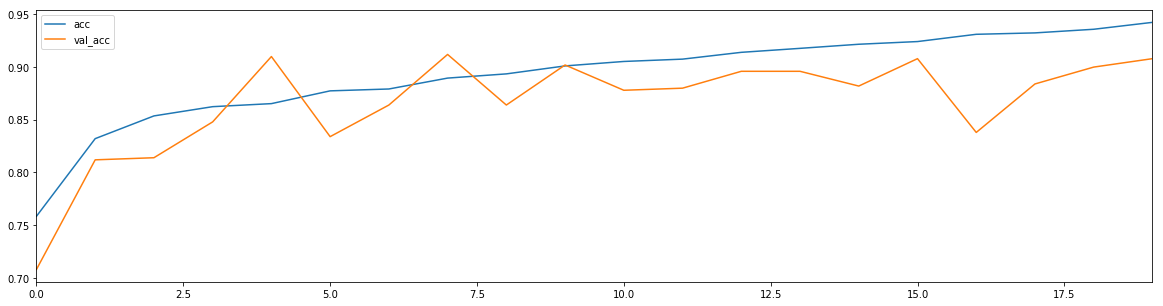

In [41]:
h = pd.DataFrame([transfer_history.history['acc'], transfer_history.history['val_acc']])
h = h.T
h.columns=['acc', 'val_acc']
h.plot(figsize=(20, 5))
plt.show()

In [42]:
transfer_model.evaluate(X_test, y_test)

500/500 [==============================] - 4s     


[0.33828231573104861, 0.86000000095367435]

In [43]:
# And fit it...
transfer_history = transfer_model.fit(X_train, y_train,
                                      batch_size=64,
                                      epochs=20,
                                      verbose=1,
                                      validation_data=(X_validation, y_validation))

Train on 9000 samples, validate on 500 samples
Epoch 1/20
9000/9000 [==============================] - 33s - loss: 0.1457 - acc: 0.9410 - val_loss: 0.2365 - val_acc: 0.9040
Epoch 2/20
9000/9000 [==============================] - 33s - loss: 0.1301 - acc: 0.9484 - val_loss: 0.2650 - val_acc: 0.8960
Epoch 3/20
9000/9000 [==============================] - 33s - loss: 0.1306 - acc: 0.9507 - val_loss: 0.2662 - val_acc: 0.8940
Epoch 4/20
9000/9000 [==============================] - 33s - loss: 0.1238 - acc: 0.9529 - val_loss: 0.2392 - val_acc: 0.9140
Epoch 5/20
9000/9000 [==============================] - 33s - loss: 0.1146 - acc: 0.9553 - val_loss: 0.3026 - val_acc: 0.8820
Epoch 6/20
9000/9000 [==============================] - 33s - loss: 0.1081 - acc: 0.9586 - val_loss: 0.2768 - val_acc: 0.8980
Epoch 7/20
9000/9000 [==============================] - 33s - loss: 0.1009 - acc: 0.9630 - val_loss: 0.3066 - val_acc: 0.9040
Epoch 8/20
9000/9000 [==============================] - 33s - loss: 0.0

In [44]:
transfer_model.evaluate(X_test, y_test)

500/500 [==============================] - 1s     


[0.45588628101348877, 0.88199999904632564]

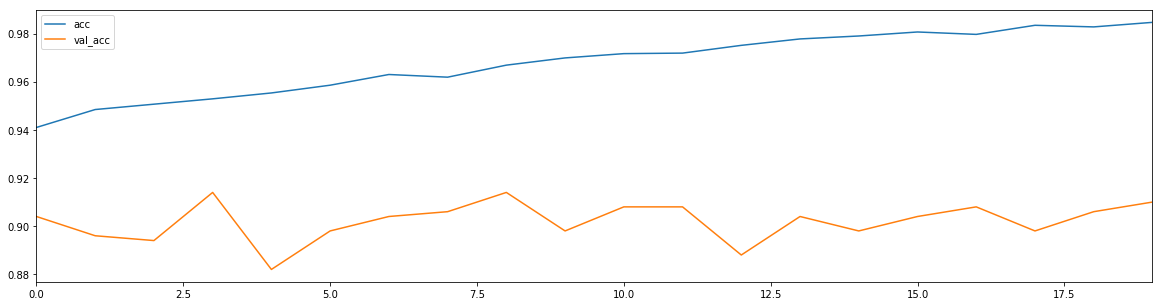

In [45]:
h = pd.DataFrame([transfer_history.history['acc'], transfer_history.history['val_acc']])
h = h.T
h.columns=['acc', 'val_acc']
h.plot(figsize=(20, 5))
plt.show()